In [1]:
%cd ..

/home/ekremezm/CounterfakeWorkspace/dino


In [2]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.manifold import TSNE
from torch.nn.functional import normalize

import dataset
import vision_transformer as vits 

# Model Load

In [3]:
dict_path      = "results/all_in_moda_test_v0.1/checkpoint.pth"
arch           = "vit_tiny"
checkpoint_key = "student"
patch_size     = 16

device = "cuda" if torch.cuda.is_available() else 'cpu'

In [4]:
backbone_model = vits.__dict__[arch](patch_size = patch_size, num_classes = 0) 

In [5]:
if "vit" in arch:
    model = vits.__dict__[arch](patch_size = patch_size, num_classes = 0)

elif "xcit" in arch:
    model = torch.hub.load('facebookresearch/xcit:main', arch, num_classes=0)

elif arch in torchvision_models.__dict__.keys():
    model = torchvision_models.__dict__[arch](num_classes=0)
    model.fc = nn.Identity()

## LoadModel

In [6]:
state_dict = torch.load(dict_path, map_location = "cpu")

In [7]:
state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}

In [8]:
state_dict = state_dict[checkpoint_key]

state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}

model.load_state_dict(state_dict, strict = False)

model = model.to(device)
model = model.eval()

# Dataloader

In [9]:
transforms = dataset.get_valid_transforms(224)
dataloader = dataset.get("data", "all_in_moda_validation_dataset", 
                         transforms, 16)

# Extract Features

In [ ]:
process = tqdm(dataloader, total = len(dataloader), ncols = 500)
classes = dataloader.dataset.classes

dataset_list = []

for samples, labels in process:
    if device == "cuda":
        samples = samples.cuda(non_blocking=True)
        labels  = labels.cuda(non_blocking=True)
    
    feats = model(samples)
    feats = normalize(feats)
    
    for i in range(len(labels)):
        label = labels[i]
        feat  = feats[i]
        dataset_list.append({
                             "label" : classes[label.item()],
                             "feat"  : feat.cpu().detach().numpy(),
                            })


  0%|                                                                                                         …

In [ ]:
df = pd.DataFrame(dataset_list)

# TSNE Graph

In [12]:
X = np.array(df['feat'].to_list())
X = np.reshape(X, (X.shape[0], -1))

X_tsne = TSNE(verbose = 1, random_state = 42).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1880 samples in 0.012s...
[t-SNE] Computed neighbors for 1880 samples in 0.728s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1880
[t-SNE] Computed conditional probabilities for sample 1880 / 1880
[t-SNE] Mean sigma: 0.312511
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.249542
[t-SNE] KL divergence after 1000 iterations: 0.961527


(-75.0, 75.0)

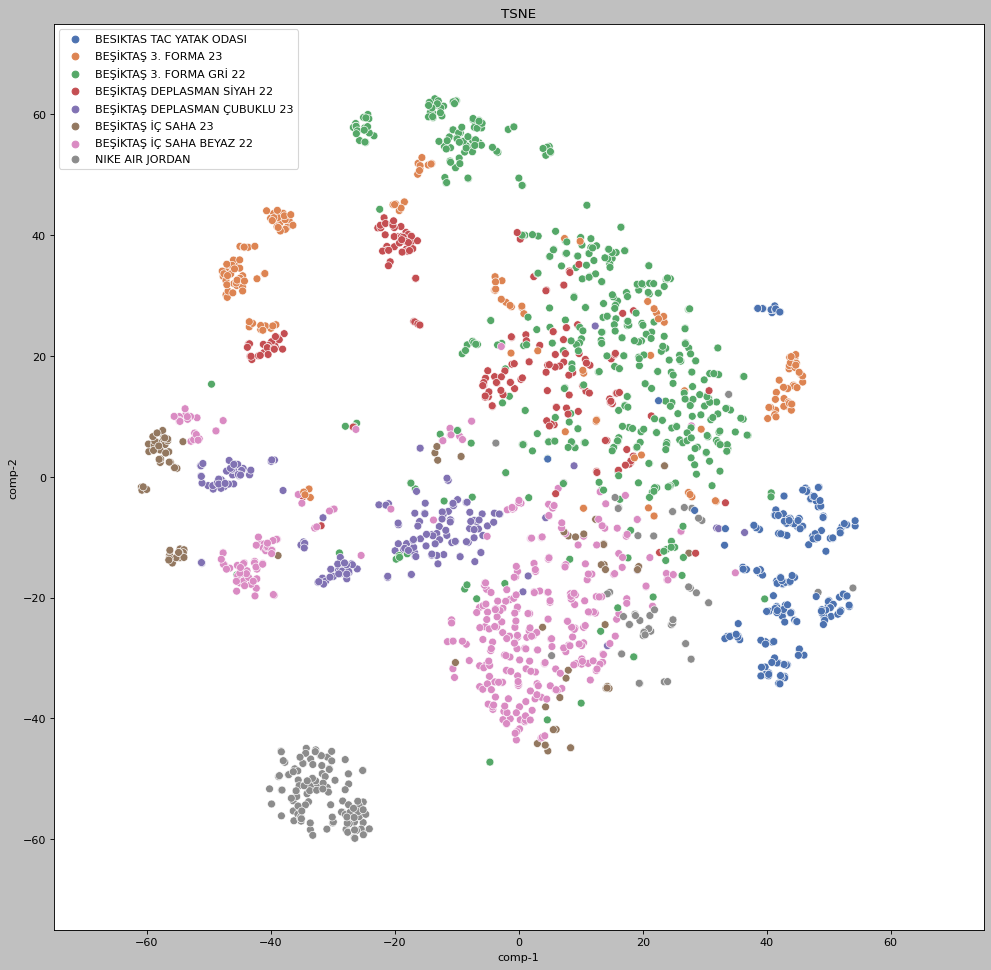

In [13]:
df["comp-1"] = X_tsne[:,0]
df["comp-2"] = X_tsne[:,1]

plt.figure(figsize = (15, 15), dpi = 80, facecolor = 'silver', edgecolor = 'gray')

sns.scatterplot(x = "comp-1", y = "comp-2", 
                hue = "label", s = 50,
                hue_order = classes,
                palette = "deep",
                data = df).set(title = "TSNE")

plt.legend(loc = 'upper left')
plt.xlim([-75, 75])
plt.ylim([-75, 75])